In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)
sns.set(style='whitegrid')

country = "sierraleon"
RAW_PATH = "../raw/sierraleone-bumbuna.csv"  
CLEAN_OUT = f"data/{country}_clean.csv"


os.makedirs(os.path.dirname(CLEAN_OUT), exist_ok=True)

print(f"Looking for raw data at: {RAW_PATH}")
print(f"Raw file exists: {os.path.exists(RAW_PATH)}")
print(f"Current working directory: {os.getcwd()}")

Looking for raw data at: ../raw/sierraleone-bumbuna.csv
Raw file exists: True
Current working directory: c:\Users\weldi\Desktop\WEEk_1\solar-challenge-week0\notebooks


In [2]:
df_raw = pd.read_csv(RAW_PATH, parse_dates=['Timestamp'])
df = df_raw.copy()

print("rows, cols:", df.shape)
display(df.head(3))


rows, cols: (525600, 19)


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-30 00:01:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.1,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
1,2021-10-30 00:02:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
2,2021-10-30 00:03:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN


In [3]:

df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()


if 'timestamp' not in df.columns:
   
    for c in df.columns:
        if 'time' in c:
            df.rename(columns={c: 'timestamp'}, inplace=True)
            break

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.sort_values('timestamp').reset_index(drop=True)
df.set_index('timestamp', inplace=True)
print("index dtype:", df.index.dtype)

index dtype: datetime64[ns]


In [4]:

num_df = df.select_dtypes(include=[np.number])
display(num_df.describe().T)

missing = df.isna().sum().to_frame('n_missing')
missing['pct_missing'] = missing['n_missing'] / len(df) * 100
missing = missing.sort_values('pct_missing', ascending=False)
display(missing.head(30))

cols_over_5pct = missing[missing['pct_missing'] > 5].index.tolist()
print("Columns with >5% missing:", cols_over_5pct)

,count,mean,std,min,25%,50%,75%,max
ghi,525600.0,201.957515,298.495150,-19.5,-2.8,0.3,362.4,1499.0
dni,525600.0,116.376337,218.652659,-7.8,-0.3,-0.1,107.0,946.0
dhi,525600.0,113.720571,158.946032,-17.9,-3.8,-0.1,224.7,892.0
moda,525600.0,206.643095,300.896893,0.0,0.0,3.6,359.5,1507.0
modb,525600.0,198.114691,288.889073,0.0,0.0,3.4,345.4,1473.0
tamb,525600.0,26.319394,4.398605,12.3,23.1,25.3,29.4,39.9
rh,525600.0,79.448857,20.520775,9.9,68.7,85.4,96.7,100.0
ws,525600.0,1.146113,1.239248,0.0,0.0,0.8,2.0,19.2
wsgust,525600.0,1.691606,1.617053,0.0,0.0,1.6,2.6,23.9
wsstdev,525600.0,0.363823,0.295000,0.0,0.0,0.4,0.6,4.1


,n_missing,pct_missing
comments,525600,100.0
ghi,0,0.0
dni,0,0.0
dhi,0,0.0
modb,0,0.0
moda,0,0.0
rh,0,0.0
ws,0,0.0
wsgust,0,0.0
tamb,0,0.0


Columns with >5% missing: ['comments']


In [5]:
# Cell 5: basic cleaning

n_before = len(df)
df = df[~df.index.duplicated(keep='first')]
print("Dropped duplicate timestamps:", n_before - len(df))


irr_cols = ['ghi','dni','dhi','moda','modb']
for c in irr_cols:
    if c in df.columns:
        df.loc[df[c] < 0, c] = np.nan


if 'rh' in df.columns:
    df.loc[(df['rh'] < 0) | (df['rh'] > 100), 'rh'] = np.nan

Dropped duplicate timestamps: 0


In [6]:
#Cell 6: Z-score outlier detection
from collections import defaultdict
check_cols = ['ghi','dni','dhi','moda','modb','ws','wsgust']
check_cols = [c for c in check_cols if c in df.columns]

zflags = pd.DataFrame(index=df.index)
outlier_counts = defaultdict(int)
for c in check_cols:
    series = df[c]
  
    if series.dropna().shape[0] < 10:
        continue
    z = (series - series.mean()) / series.std(ddof=0)
    zflags[c+'_z'] = z
    zflags[c+'_outlier'] = z.abs() > 3
    outlier_counts[c] = zflags[c+'_outlier'].sum()

print("Outlier counts by column:")
for c, cnt in outlier_counts.items():
    print(f"  {c}: {cnt}")


zflags['any_outlier'] = zflags[[col for col in zflags.columns if col.endswith('_outlier')]].any(axis=1)
print("Rows with any outlier:", zflags['any_outlier'].sum())
display(zflags[zflags['any_outlier']].head())


Outlier counts by column:
  ghi: 87
  dni: 0
  dhi: 388
  moda: 1604
  modb: 2041
  ws: 3967
  wsgust: 3665
Rows with any outlier: 6943


,ghi_z,ghi_outlier,dni_z,dni_outlier,dhi_z,dhi_outlier,moda_z,moda_outlier,modb_z,modb_outlier,ws_z,ws_outlier,wsgust_z,wsgust_outlier,any_outlier
timestamp,,,,,,,,,,,,,,,
2021-10-30 11:03:00,2.179089,False,1.450180,False,2.054014,False,3.108566,True,3.177296,True,-0.763458,False,-0.613218,False,True
2021-10-30 11:04:00,2.336433,False,1.669754,False,2.049320,False,3.278059,True,3.353835,True,-0.844152,False,-0.365855,False,True
2021-10-30 11:11:00,2.247927,False,1.645315,False,1.842753,False,3.178357,True,3.249989,True,0.689037,False,0.561759,False,True
2021-10-30 11:12:00,2.451164,False,1.983650,False,1.733433,False,3.424289,True,3.495758,True,0.043484,False,0.128873,False,True
2021-10-30 11:13:00,2.152865,False,1.638059,False,1.644234,False,3.075332,True,3.139219,True,-0.440681,False,-0.056650,False,True


In [8]:
# Cell 7: cap outliers (winsorize-like) OR replace with median - choose one approach

df_clean = df.copy()
for c in check_cols:
    if c in df_clean.columns:
        median = df_clean[c].median()
        mask = zflags.loc[df_clean.index, c+'_outlier'] if c+'_outlier' in zflags.columns else (False)
        df_clean.loc[mask, c] = median




In [9]:
# Cell 8: imputation

if 'Timestamp' in df_clean.columns:
    df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], errors='coerce')
    df_clean.set_index('Timestamp', inplace=True)


key_cols = ['ghi','dni','dhi','moda','modb','tamb','rh','ws']

for c in key_cols:
    if c in df_clean.columns:
        pct_missing = df_clean[c].isna().mean() * 100
        if pct_missing <= 20:
            df_clean[c] = df_clean[c].fillna(df_clean[c].median())  # ✅ safer
        else:
           
            if pd.api.types.is_numeric_dtype(df_clean[c]):
                df_clean[c] = df_clean[c].interpolate(method='time', limit=12)

# Show missing values summary
print("After median/interpolation, missing summary:")
print(df_clean.isna().sum().to_frame('n_missing_after'))


After median/interpolation, missing summary:
               n_missing_after
ghi                     255877
dni                     237045
dhi                     258265
moda                         0
modb                         0
tamb                         0
rh                           0
ws                           0
wsgust                       0
wsstdev                      0
wd                           0
wdstdev                      0
bp                           0
cleaning                     0
precipitation                0
tmoda                        0
tmodb                        0
comments                525600


In [10]:
# Cell 9: save and show counts
n_raw = len(df)
n_clean = len(df_clean)
print(f"rows before: {n_raw}, rows after cleaning: {n_clean}")


df_clean.reset_index().to_csv(CLEAN_OUT, index=False)
print("Saved cleaned file to:", CLEAN_OUT)


rows before: 525600, rows after cleaning: 525600
Saved cleaned file to: data/sierraleon_clean.csv


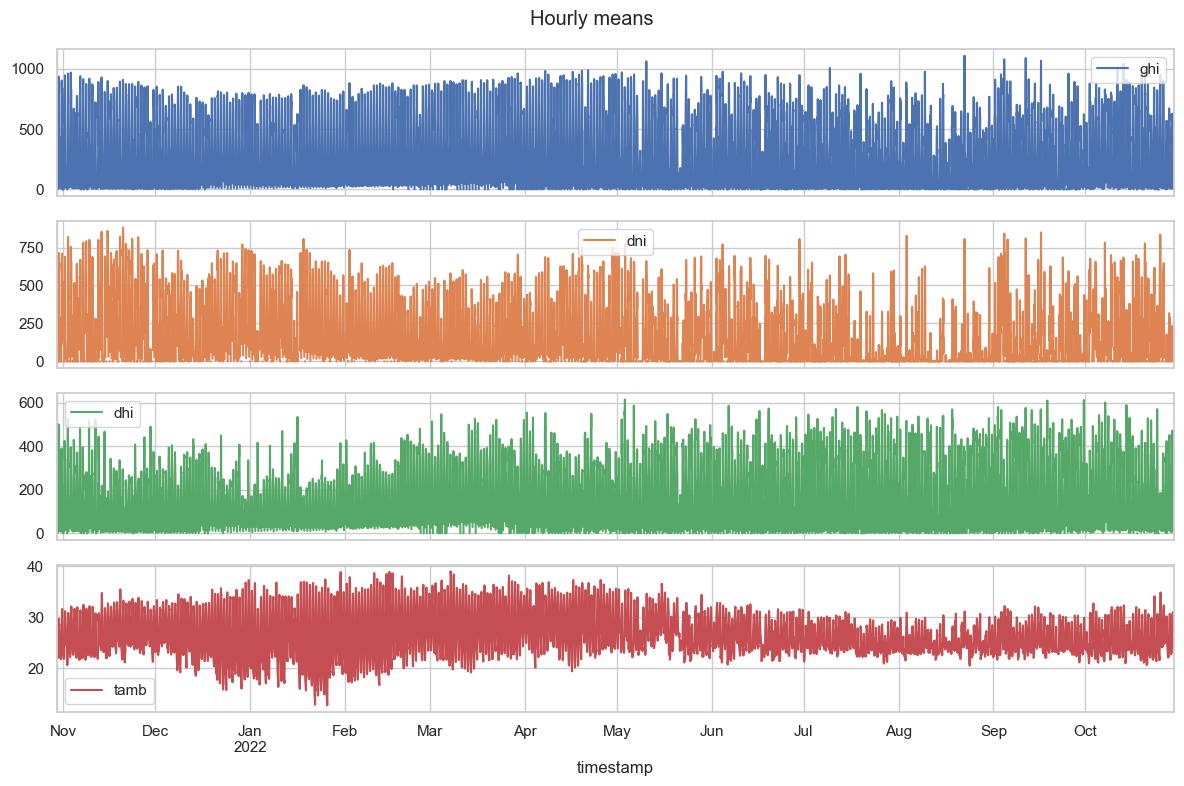

In [11]:
vars_ts = [c for c in ['ghi','dni','dhi','tamb'] if c in df_clean.columns]

if vars_ts:
    df_clean[vars_ts].resample('1h').mean().plot(
        subplots=True, figsize=(12,8), title='Hourly means'
    )
    plt.tight_layout()


Text(0.5, 1.0, 'Monthly averages')

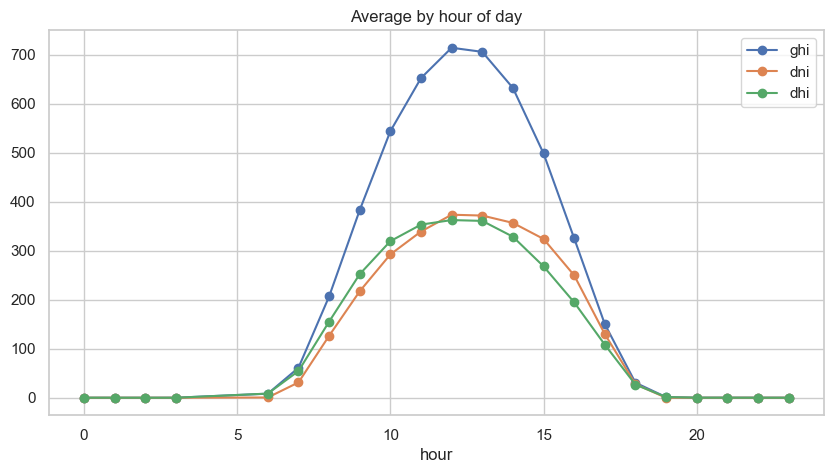

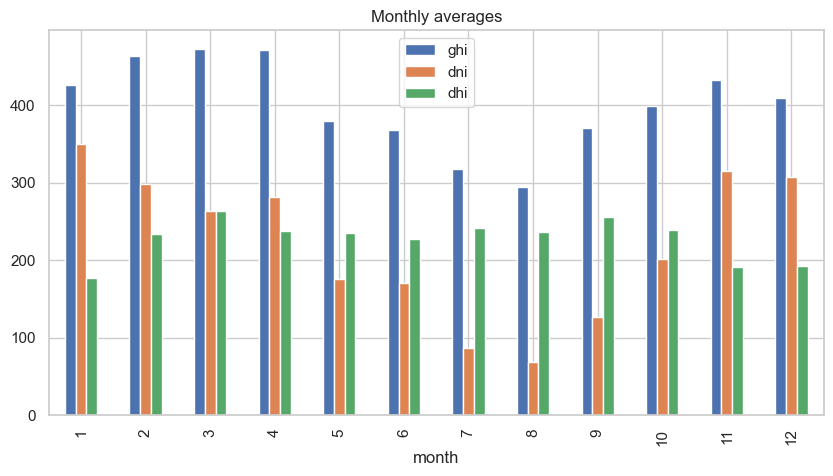

In [12]:
# Cell 11: hourly and monthly patterns
df_clean['hour'] = df_clean.index.hour
hourly = df_clean.groupby('hour')[['ghi','dni','dhi']].mean().dropna()
hourly.plot(figsize=(10,5), marker='o').set_title('Average by hour of day')

df_clean['month'] = df_clean.index.month
monthly = df_clean.groupby('month')[['ghi','dni','dhi']].mean().dropna()
monthly.plot(kind='bar', figsize=(10,5)).set_title('Monthly averages')


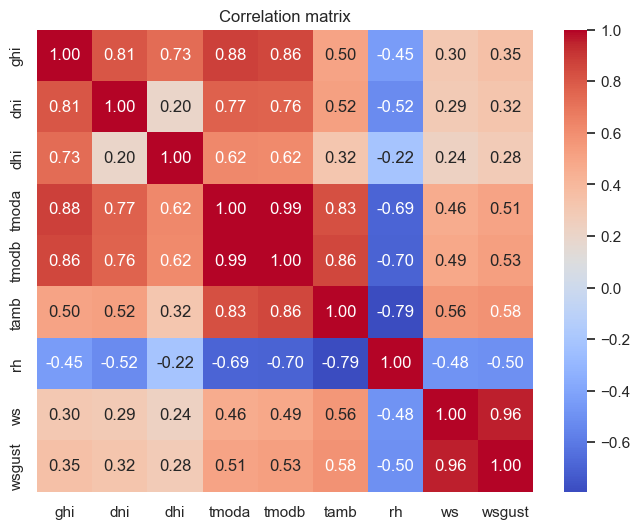

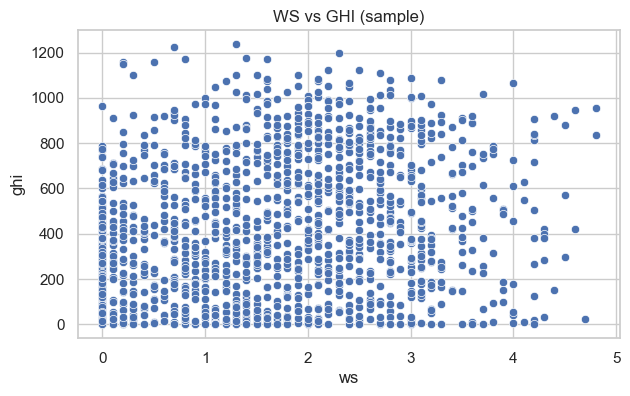

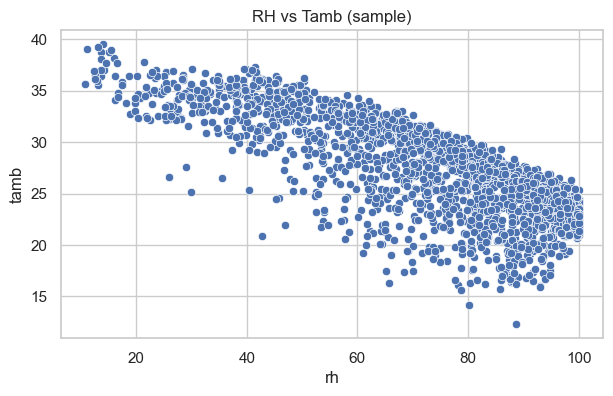

In [13]:
# Cell 12: correlation heatmap
corr_cols = [c for c in ['ghi','dni','dhi','tmoda','tmodb','tamb','rh','ws','wsgust'] if c in df_clean.columns]
plt.figure(figsize=(8,6))
sns.heatmap(df_clean[corr_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()


if 'ws' in df_clean.columns and 'ghi' in df_clean.columns:
    plt.figure(figsize=(7,4))
    sns.scatterplot(x='ws', y='ghi', data=df_clean.sample(min(3000, len(df_clean))))
    plt.title('WS vs GHI (sample)')
    plt.show()

if 'rh' in df_clean.columns and 'tamb' in df_clean.columns:
    plt.figure(figsize=(7,4))
    sns.scatterplot(x='rh', y='tamb', data=df_clean.sample(min(3000, len(df_clean))))
    plt.title('RH vs Tamb (sample)')
    plt.show()


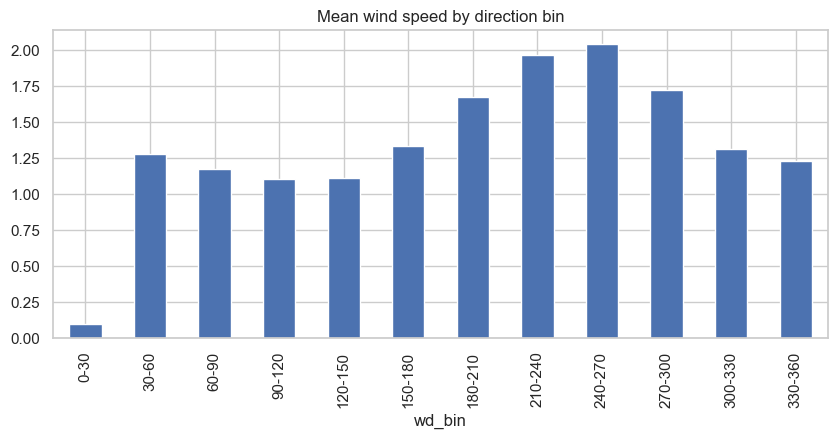

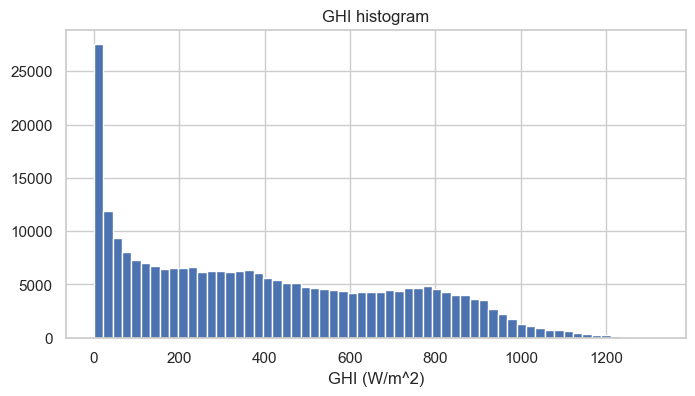

In [14]:
if {'wd','ws'}.issubset(df_clean.columns):
    df_wind = df_clean[['wd','ws']].dropna()
 
    bins = np.arange(0, 361, 30)
    labels = [f"{int(b)}-{int(b+30)}" for b in bins[:-1]]
    df_wind['wd_bin'] = pd.cut(df_wind['wd'] % 360, bins=bins, labels=labels, include_lowest=True)
    windrose = df_wind.groupby('wd_bin', observed=False)['ws'].mean().reindex(labels)
    windrose.plot(kind='bar', figsize=(10,4)).set_title('Mean wind speed by direction bin')
    plt.show()

if 'ghi' in df_clean.columns:
    plt.figure(figsize=(8,4))
    df_clean['ghi'].hist(bins=60)
    plt.title('GHI histogram')
    plt.xlabel('GHI (W/m^2)')
    plt.show()


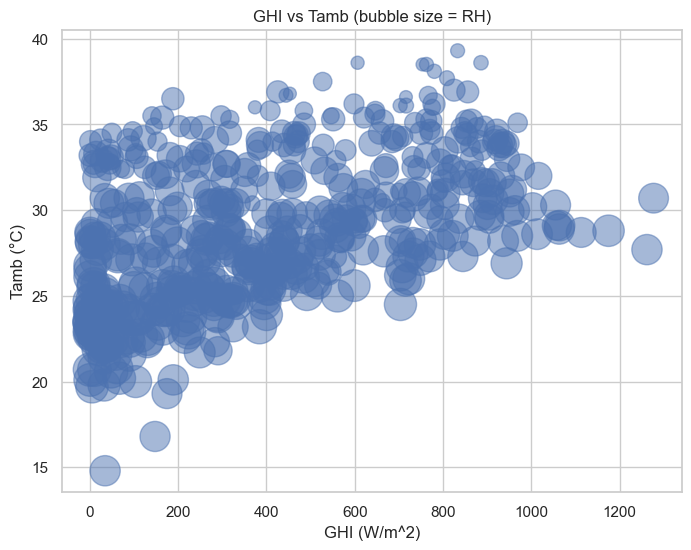

In [15]:
# Cell 14: bubble chart
if {'ghi','tamb','rh'}.issubset(df_clean.columns):
    sample = df_clean.sample(min(1000, len(df_clean))).dropna(subset=['ghi','tamb','rh'])
    plt.figure(figsize=(8,6))
    plt.scatter(sample['ghi'], sample['tamb'], s=(sample['rh']+1)*6, alpha=0.5)
    plt.xlabel('GHI (W/m^2)'); plt.ylabel('Tamb (°C)')
    plt.title('GHI vs Tamb (bubble size = RH)')
    plt.show()


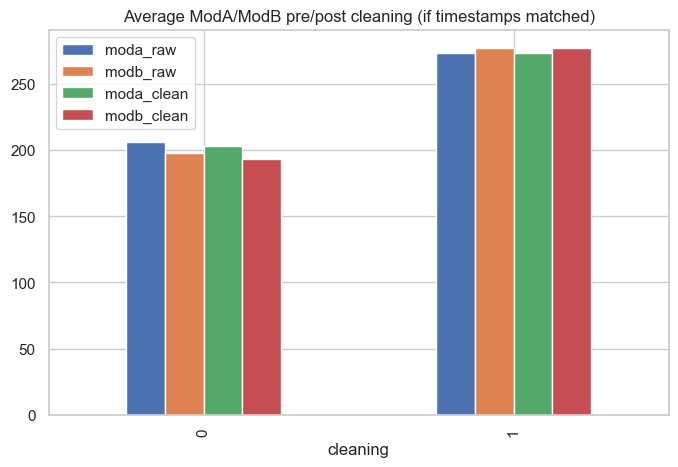

In [16]:
# Cell 15: cleaning impact

df_raw2 = df_raw.copy()
df_raw2.columns = df_raw2.columns.str.strip().str.replace(' ', '_').str.lower()
if 'cleaning' in df_raw2.columns and {'moda','modb'}.issubset(df_clean.columns):
    
    df_raw2['timestamp'] = pd.to_datetime(df_raw2['timestamp'], errors='coerce')
    df_raw2.set_index('timestamp', inplace=True)
    merged = pd.concat([
        df_raw2[['moda','modb','cleaning']].rename(columns={'moda':'moda_raw','modb':'modb_raw'}),
        df_clean[['moda','modb']].rename(columns={'moda':'moda_clean','modb':'modb_clean'})
    ], axis=1)
 
    if 'cleaning' in merged.columns:
        merged.groupby('cleaning')[['moda_raw','modb_raw','moda_clean','modb_clean']].mean().plot(kind='bar', figsize=(8,5))
        plt.title('Average ModA/ModB pre/post cleaning (if timestamps matched)')
        plt.show()
else:
    print("No cleaning flag found or ModA/ModB missing to compare.")


In [17]:
# Cell 16: quick KPI table and markdown outputs to record
kpi = {}
kpi['n_rows_raw'] = n_raw
kpi['n_rows_clean'] = n_clean
kpi['n_cols'] = df.shape[1]
kpi['cols_over_5pct_missing'] = cols_over_5pct
kpi_df = pd.DataFrame([kpi])
display(kpi_df.T)



,0
n_rows_raw,525600
n_rows_clean,525600
n_cols,18
cols_over_5pct_missing,[comments]
